# AIPI 590 - XAI | Adversarial Patches

Description: 

Christian Moreira

### Importing Libraries

In [1]:
## Standard libraries
import os
import json
import math
import time
import numpy as np
import scipy.linalg
from PIL import Image

## Imports for plotting
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline # <-- FIX 1
%matplotlib inline
# from IPython.display import set_matplotlib_formats
matplotlib_inline.backend_inline.set_matplotlib_formats('svg', 'pdf') # <-- FIX 1
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default.
    !pip install --quiet pytorch_lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# --- Paths ---
# Path to the folder where the datasets are/should be downloaded
DATASET_PATH = "data"  # <-- CORRECTED PATH
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "saved_models/tutorial10" # <-- CORRECTED PATH
# Path for our custom-generated patch
CUSTOM_PATCH_PATH = os.path.join(CHECKPOINT_PATH, "custom")
os.makedirs(CUSTOM_PATCH_PATH, exist_ok=True)
# Path to our logo
LOGO_PATH = os.path.join(DATASET_PATH, "ung_logo.png") # <-- CORRECTED PATH

# --- Reproducibility ---
pl.seed_everything(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# --- Device ---
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)
print(f"Custom patch will be saved to: {CUSTOM_PATCH_PATH}")
print(f"Looking for logo at: {LOGO_PATH}")

Seed set to 42


Using device cpu
Custom patch will be saved to: saved_models/tutorial10\custom
Looking for logo at: data\ung_logo.png


In [2]:
import urllib.request
from urllib.error import HTTPError
import zipfile

# Github URL where the dataset is stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial10/"
# Files to download
pretrained_files = [(DATASET_PATH, "TinyImageNet.zip"), (CHECKPOINT_PATH, "patches.zip")]

# Create checkpoint path if it doesn't exist yet
os.makedirs(DATASET_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for dir_name, file_name in pretrained_files:
    file_path = os.path.join(dir_name, file_name)
    if not os.path.isfile(file_path):
        # --- THIS LINE IS NOW FIXED ---
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)
        if file_name.endswith(".zip"):
            print("Unzipping file...")
            with zipfile.ZipFile(file_path, 'r') as zip_ref:
                # --- THIS IS FIX 2 (for Windows) ---
                zip_ref.extractall(dir_name)

Unzipping file...
Unzipping file...


In [3]:
# Load CNN architecture pretrained on ImageNet
os.environ["TORCH_HOME"] = CHECKPOINT_PATH
pretrained_model = torchvision.models.resnet34(weights='IMAGENET1K_V1')
pretrained_model = pretrained_model.to(device)

# No gradients needed for the network
pretrained_model.eval()
for p in pretrained_model.parameters():
    p.requires_grad = False

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to saved_models/tutorial10\hub\checkpoints\resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:02<00:00, 35.7MB/s]


In [4]:
# Mean and Std from ImageNet
NORM_MEAN = np.array([0.485, 0.456, 0.406])
NORM_STD = np.array([0.229, 0.224, 0.225])

# No resizing and center crop necessary as images are already preprocessed.
plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=NORM_MEAN,
                         std=NORM_STD)])

# Load dataset and create data loader
imagenet_path = os.path.join(DATASET_PATH, "TinyImageNet/")
assert os.path.isdir(imagenet_path), f"Could not find the ImageNet dataset at expected path \"{imagenet_path}\". " + \
                                     f"Please make sure to have downloaded the ImageNet dataset here, or change the {DATASET_PATH=} variable."
dataset = torchvision.datasets.ImageFolder(root=imagenet_path, transform=plain_transforms)

# --- THIS IS FIX 3 (for Windows) ---
data_loader = data.DataLoader(dataset, batch_size=32, shuffle=False, drop_last=False, num_workers=0)

# Load label names to interpret the label numbers 0 to 999
with open(os.path.join(imagenet_path, "label_list.json"), "r") as f:
    label_names = json.load(f)

def get_label_index(lab_str):
    assert lab_str in label_names, f"Label \"{lab_str}\" not found. Check the spelling of the class."
    return label_names.index(lab_str)

In [5]:


target_class_name = 'ashcan' 
target_class_idx = 412

assert target_class_name in label_names, "Target class name not in label list!"

print(f"Target Acquired! We will make the model see: **{target_class_name}** (Index: {target_class_idx})")
print("This class is also known as: 'trash can, garbage can, wastebin...'")

Target Acquired! We will make the model see: **ashcan** (Index: 412)
This class is also known as: 'trash can, garbage can, wastebin...'


In [6]:
def eval_model(dataset_loader, img_func=None):
    tp, tp_5, counter = 0., 0., 0.
    for imgs, labels in tqdm(dataset_loader, desc="Validating..."):
        imgs = imgs.to(device)
        labels = labels.to(device)
        if img_func is not None:
            imgs = img_func(imgs, labels)
        with torch.no_grad():
            preds = pretrained_model(imgs)
        tp += (preds.argmax(dim=-1) == labels).sum()
        tp_5 += (preds.topk(5, dim=-1)[1] == labels[...,None]).any(dim=-1).sum()
        counter += preds.shape[0]
    acc = tp.float().item()/counter
    top5 = tp_5.float().item()/counter
    print(f"Top-1 error: {(100.0 * (1 - acc)):4.2f}%")
    print(f"Top-5 error: {(100.0 * (1 - top5)):4.2f}%")
    return acc, top5

def show_prediction(img, label, pred, K=5, adv_img=None, noise=None):
    if isinstance(img, torch.Tensor):
        img = img.cpu().permute(1, 2, 0).numpy()
        img = (img * NORM_STD[None,None]) + NORM_MEAN[None,None]
        img = np.clip(img, a_min=0.0, a_max=1.0)
        label = label.item()
    if abs(pred.sum().item() - 1.0) > 1e-4:
        pred = torch.softmax(pred, dim=-1)
    
    fig, ax = plt.subplots(1, 2, figsize=(10,2), gridspec_kw={'width_ratios': [1, 1]})
    ax[0].imshow(img)
    ax[0].set_title(label_names[label])
    ax[0].axis('off')

    topk_vals, topk_idx = pred.topk(K, dim=-1)
    topk_vals, topk_idx = topk_vals.cpu().numpy(), topk_idx.cpu().numpy()
    ax[-1].barh(np.arange(K), topk_vals*100.0, align='center', color=["C0" if topk_idx[i]!=label else "C2" for i in range(K)])
    ax[-1].set_yticks(np.arange(K))
    ax[-1].set_yticklabels([label_names[c] for c in topk_idx])
    ax[-1].invert_yaxis()
    ax[-1].set_xlabel('Confidence')
    ax[-1].set_title('Predictions')

    plt.show()
    plt.close()

# Grab a batch of images for later testing
exmp_batch, label_batch = next(iter(data_loader))

In [7]:
TENSOR_MEANS = torch.FloatTensor(NORM_MEAN).to(device)[:,None,None]
TENSOR_STD = torch.FloatTensor(NORM_STD).to(device)[:,None,None]

def patch_forward(patch):
    # This maps the patch nn.Parameter (which is unbound) to the
    # correct normalized image space.
    # 1. torch.tanh(patch): -> [-1, 1]
    # 2. (... + 1) / 2:      -> [0, 1] (pixel space)
    # 3. (... - MEANS) / STD: -> normalized space
    patch_0_1 = (torch.tanh(patch) + 1) / 2
    return (patch_0_1 - TENSOR_MEANS) / TENSOR_STD

def place_patch(img, patch):
    for i in range(img.shape[0]):
        # Randomly place patch
        h_offset = np.random.randint(0,img.shape[2]-patch.shape[2]-1)
        w_offset = np.random.randint(0,img.shape[3]-patch.shape[1]-1)
        # Apply the patch
        img[i,:,h_offset:h_offset+patch.shape[2],w_offset:w_offset+patch.shape[1]] = patch_forward(patch)
    return img

def eval_patch(model, patch, val_loader, target_class):
    model.eval()
    tp, tp_5, counter = 0., 0., 0.
    with torch.no_grad():
        for img, img_labels in tqdm(val_loader, desc="Validating...", leave=False):
            # For stability, place the patch at 4 random locations per image
            for _ in range(4):
                patch_img = place_patch(img.clone(), patch)
                patch_img = patch_img.to(device)
                img_labels = img_labels.to(device)
                pred = model(patch_img)
                # We count a "success" if the model predicts our target class
                # AND the image was not already our target class.
                tp += torch.logical_and(pred.argmax(dim=-1) == target_class, img_labels != target_class).sum()
                tp_5 += torch.logical_and((pred.topk(5, dim=-1)[1] == target_class).any(dim=-1), img_labels != target_class).sum()
                counter += (img_labels != target_class).sum()
    
    # Handle the case where counter is zero (e.g., if all images are the target class)
    if counter.item() == 0:
        return torch.tensor(0.0), torch.tensor(0.0)
        
    acc = tp.float() / counter
    top5 = tp_5.float() / counter
    return acc, top5

Successfully loaded and processed logo into a torch.Size([3, 64, 64]) tensor.


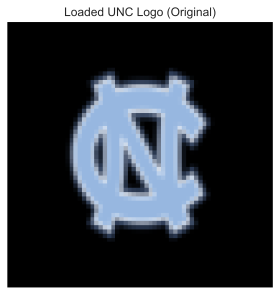

In [8]:
PATCH_SIZE = 64 # We'll create a 64x64 patch

# Load the logo
assert os.path.isfile(LOGO_PATH), f"File not found at {LOGO_PATH}. Please add ung_logo.png to data/"
logo_img = Image.open(LOGO_PATH).convert("RGB")

# Define transforms to make it a 64x64 tensor
data_transforms = transforms.Compose([
    transforms.Resize((PATCH_SIZE, PATCH_SIZE)),
    transforms.ToTensor() # This scales pixels to [0, 1]
])

# Apply transforms
logo_tensor_0_1 = data_transforms(logo_img) # Shape [3, 64, 64], range [0, 1]

# --- Inverse of patch_forward ---
# We need to convert our [0, 1] logo tensor into the
# "unbound" space that tanh() will map *back* to our logo.
# 1. [0, 1] -> [-1, 1]
logo_tensor_m1_1 = (logo_tensor_0_1 * 2.0) - 1.0
# 2. Clamp to avoid inf/-inf from arctanh
logo_tensor_m1_1_clamped = torch.clamp(logo_tensor_m1_1, min=-1.0+1e-7, max=1.0-1e-7)
# 3. Apply arctanh (inverse of tanh)
patch_init_unbound = torch.arctanh(logo_tensor_m1_1_clamped)
patch_init_unbound = patch_init_unbound.to(device)

print(f"Successfully loaded and processed logo into a {patch_init_unbound.shape} tensor.")

# Let's visualize the logo to make sure it loaded correctly
plt.imshow(logo_tensor_0_1.permute(1, 2, 0).numpy())
plt.title("Loaded UNC Logo (Original)")
plt.axis('off')
plt.show()

In [9]:
def custom_patch_attack(model, target_class, patch_init_tensor, num_epochs=10):
    # Create the training/validation split
    train_set, val_set = torch.utils.data.random_split(dataset, [4500, 500])
    
    # --- THIS IS FIX 3 (for Windows) ---
    train_loader = data.DataLoader(train_set, batch_size=32, shuffle=True, drop_last=True, num_workers=0)
    val_loader = data.DataLoader(val_set, batch_size=32, shuffle=False, drop_last=False, num_workers=0)

    # *** THIS IS THE KEY CHANGE ***
    # Initialize the patch parameter with our logo tensor
    patch = nn.Parameter(patch_init_tensor.clone(), requires_grad=True)

    # Use Adam optimizer, which works well for fine-tuning
    optimizer = torch.optim.Adam([patch], lr=0.01)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
    loss_module = nn.CrossEntropyLoss()

    print(f"Starting attack. Tuning patch to target class '{label_names[target_class]}'")
    
    # Training loop
    for epoch in range(num_epochs):
        train_loss = 0.0
        t = tqdm(train_loader, leave=False)
        model.train() # Not strictly necessary, but good practice
        for img, _ in t:
            # Place the patch on the batch of images
            img = place_patch(img.clone(), patch)
            img = img.to(device)
            
            # Forward pass
            pred = model(img)
            # Create a tensor of our target class
            labels = torch.zeros(img.shape[0], device=pred.device, dtype=torch.long).fill_(target_class)
            
            # Calculate loss
            loss = loss_module(pred, labels)
            
            # Backward pass
            optimizer.zero_grad()
            loss.mean().backward()
            optimizer.step()
            
            train_loss += loss.item()
            t.set_description(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():4.2f}")
        
        avg_train_loss = train_loss / len(train_loader)
        scheduler.step(avg_train_loss)
        print(f"Epoch {epoch+1} finished. Avg Loss: {avg_train_loss:4.2f}")

    # Final validation
    print("Training finished. Running final validation...")
    acc, top5 = eval_patch(model, patch, val_loader, target_class)

    return patch.data, {"acc": acc.item(), "top5": top5.item()}

In [ ]:
# target_class_idx and target_class_name were defined in Cell 5
print(f"Starting attack... Target: '{target_class_name}' ({target_class_idx})")

# Run the attack
custom_patch_tensor, val_results = custom_patch_attack(
    pretrained_model, 
    target_class=target_class_idx, 
    patch_init_tensor=patch_init_unbound,
    num_epochs=10 # Feel free to increase this if needed
)
                               
print(f"Validation results for '{target_class_name}':")
print(f"  Top-1 Fooling Accuracy: {val_results['acc']*100.0:4.2f}%")
print(f"  Top-5 Fooling Accuracy: {val_results['top5']*100.0:4.2f}%")

# Save the final patch tensor
patch_filename = os.path.join(CUSTOM_PATCH_PATH, f"unc_to_{target_class_name.replace(' ', '_')}_patch.pt")
torch.save(custom_patch_tensor, patch_filename)
print(f"Patch tensor saved to {patch_filename}")

Starting attack... Target: 'ashcan' (412)
Starting attack. Tuning patch to target class 'ashcan'


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 1 finished. Avg Loss: 10.61


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch 2 finished. Avg Loss: 9.48


  0%|          | 0/140 [00:00<?, ?it/s]